In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from mm_env import SimpleEnv
import pandas as pd
from utils import evaluate, single_experiment, multiple_experiment
from dataclasses import dataclass

/opt/anaconda3/lib/python3.8/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [2]:
%run './all_agents.ipynb' # import all agents

In [3]:
env = SimpleEnv(debug=False, T=100, lambda_neg=15, lambda_pos=10, kappa=10, Q=4)

### Random

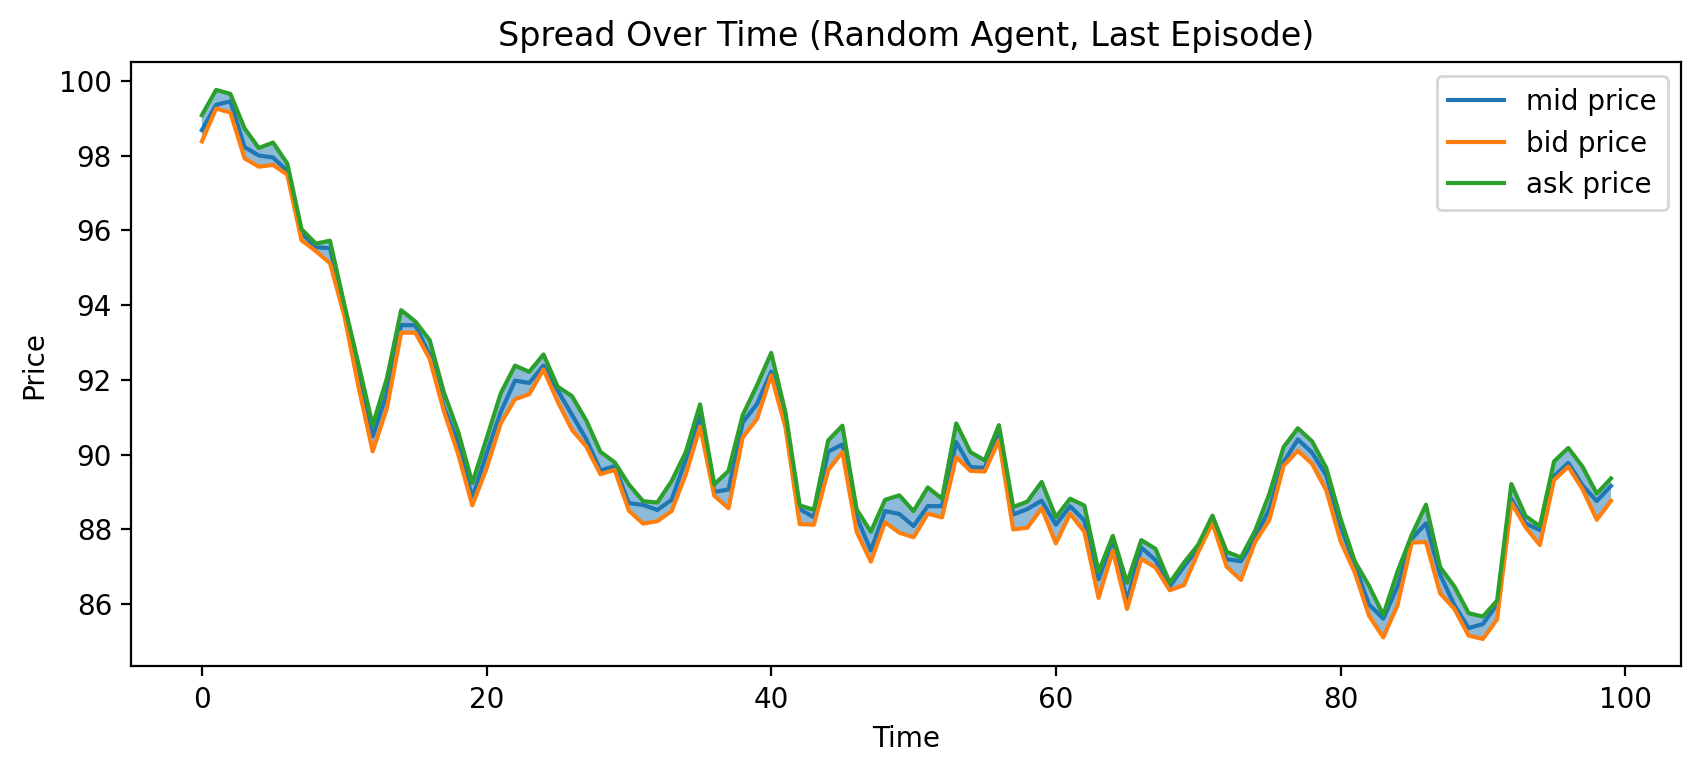

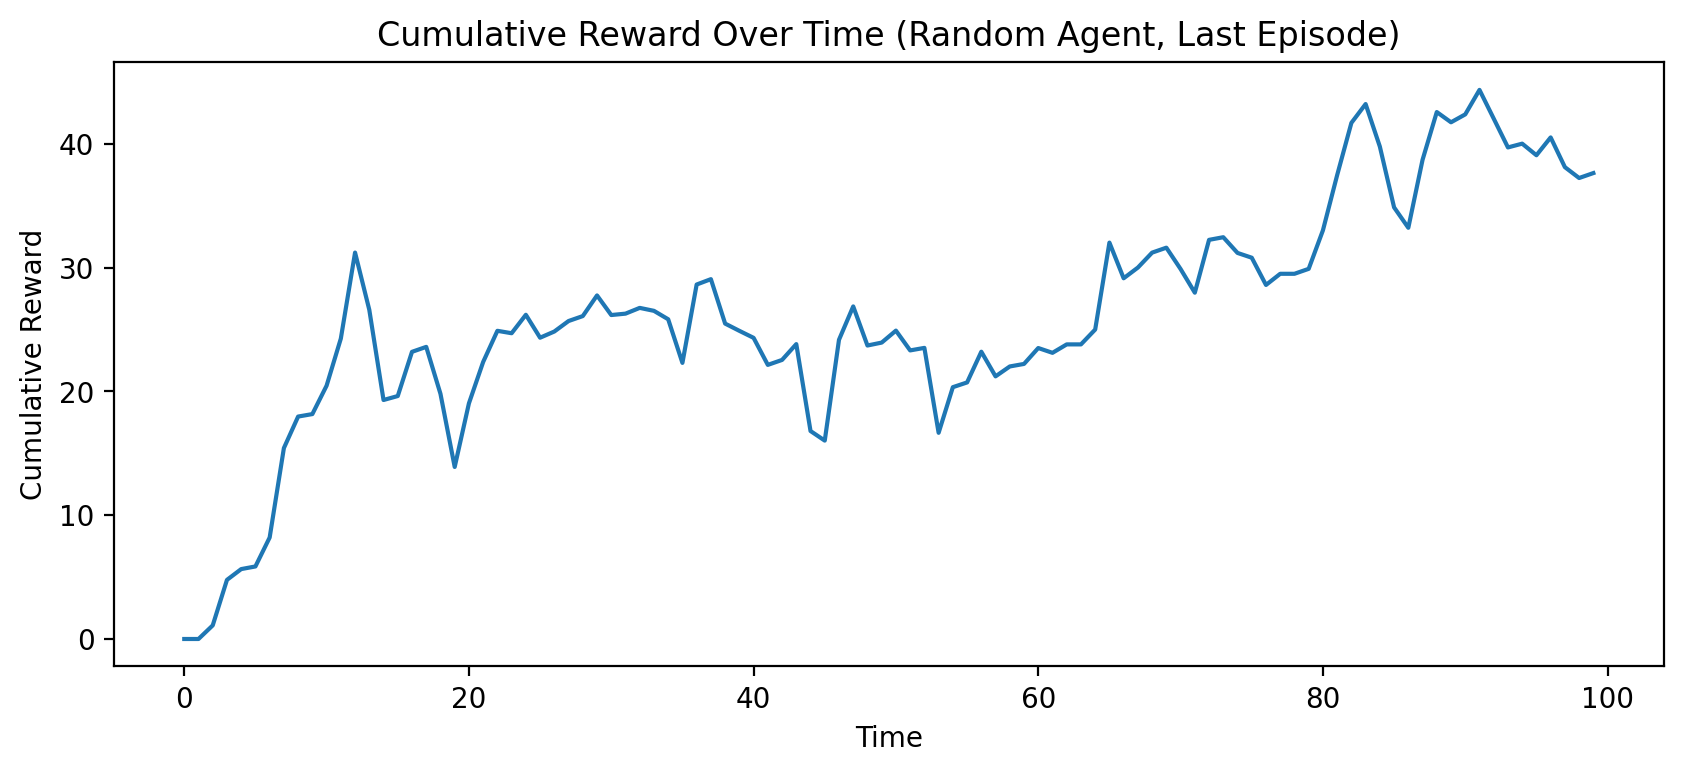

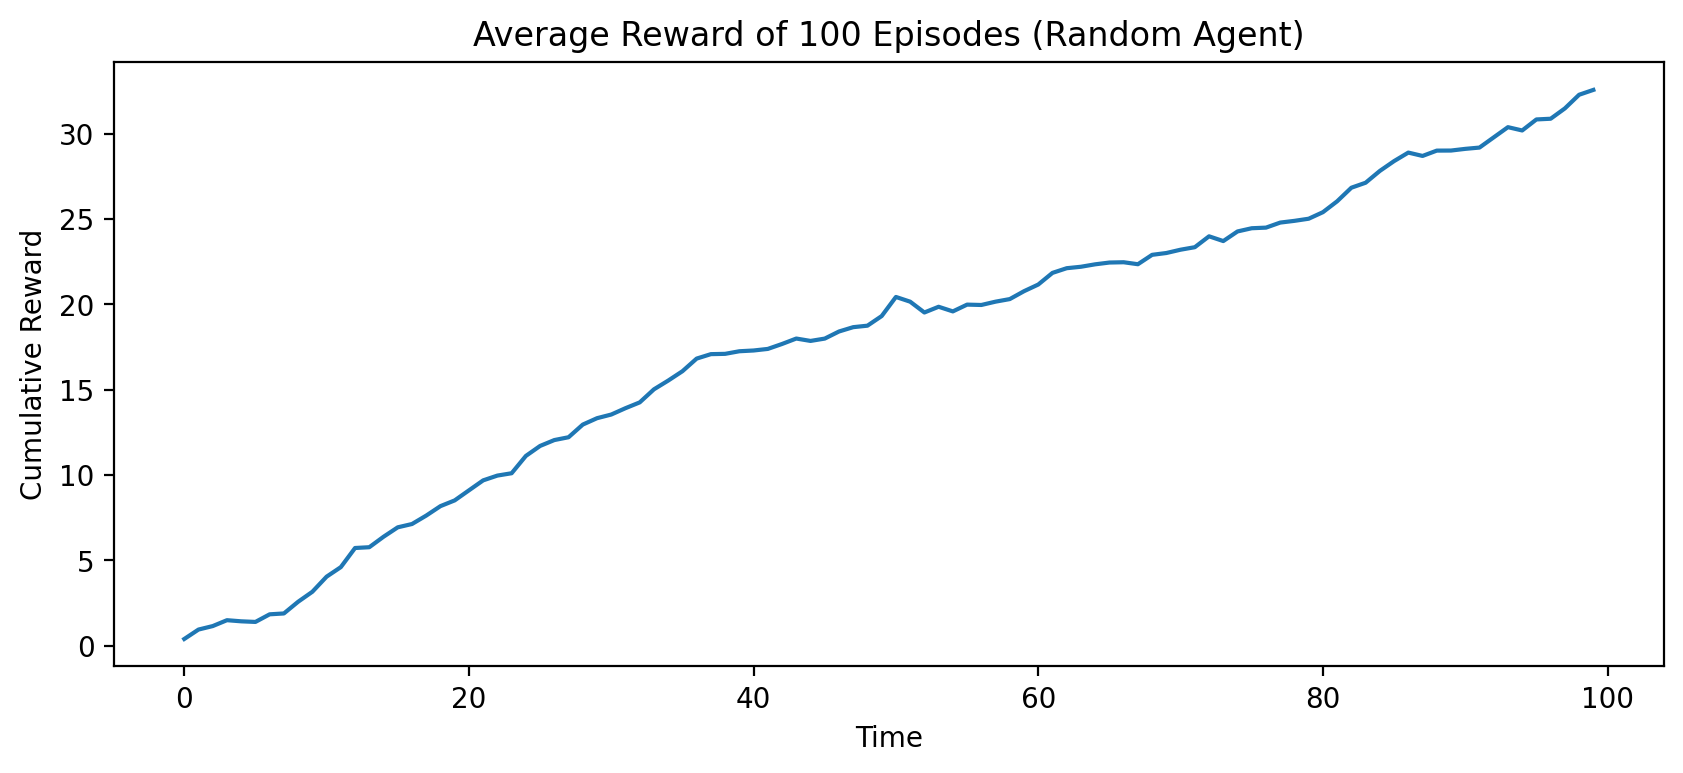

In [5]:
agent_random = RandomAgent(env_d=env.d)
logs_random, final_rewards_random, average_rewards_random = multiple_experiment(
    agent_name='Random Agent', agent=agent_random, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Q Learning

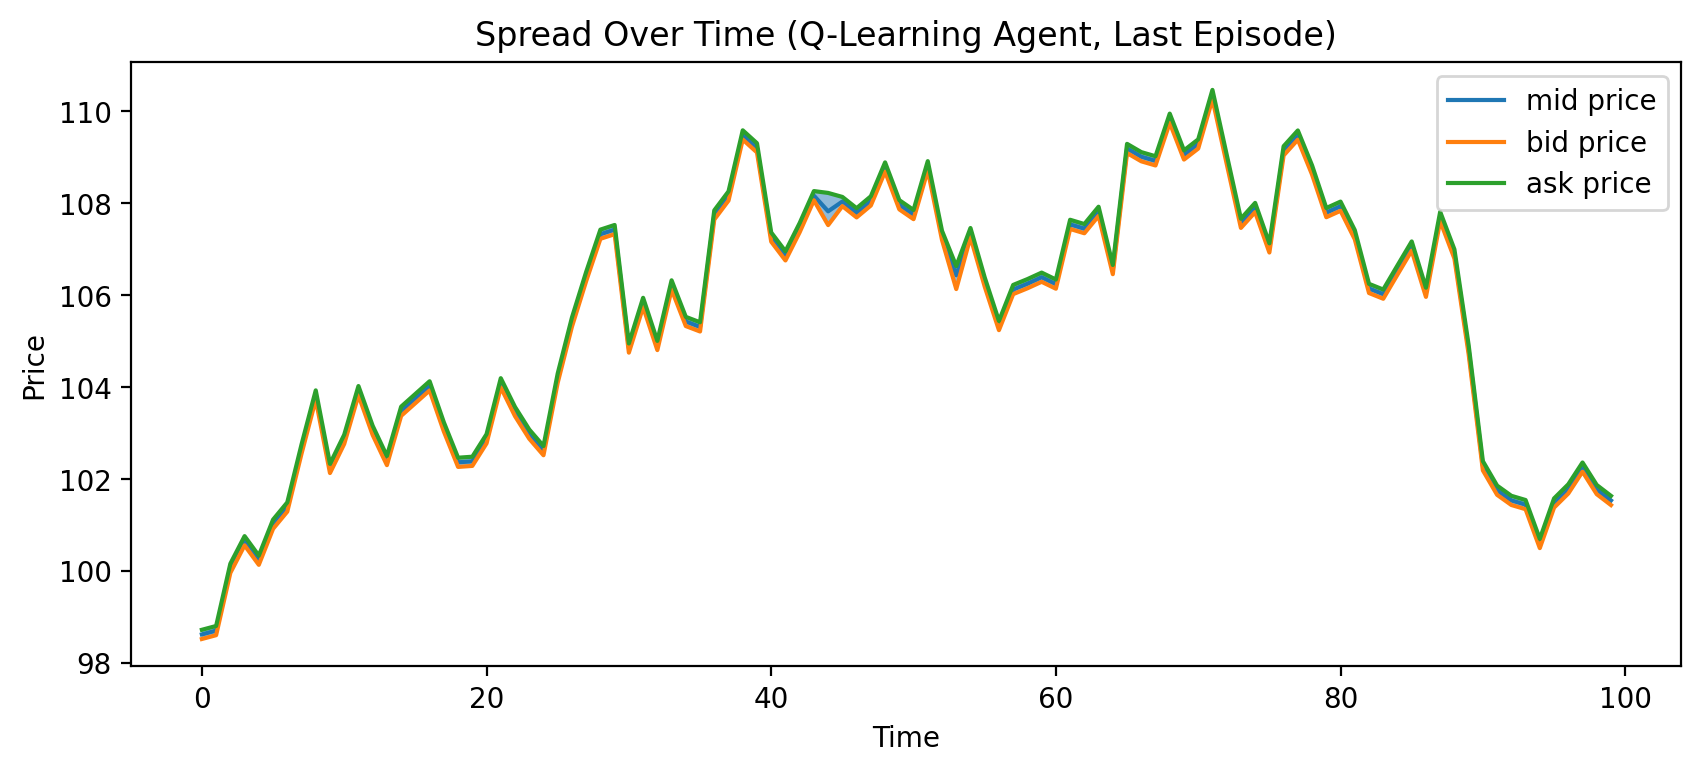

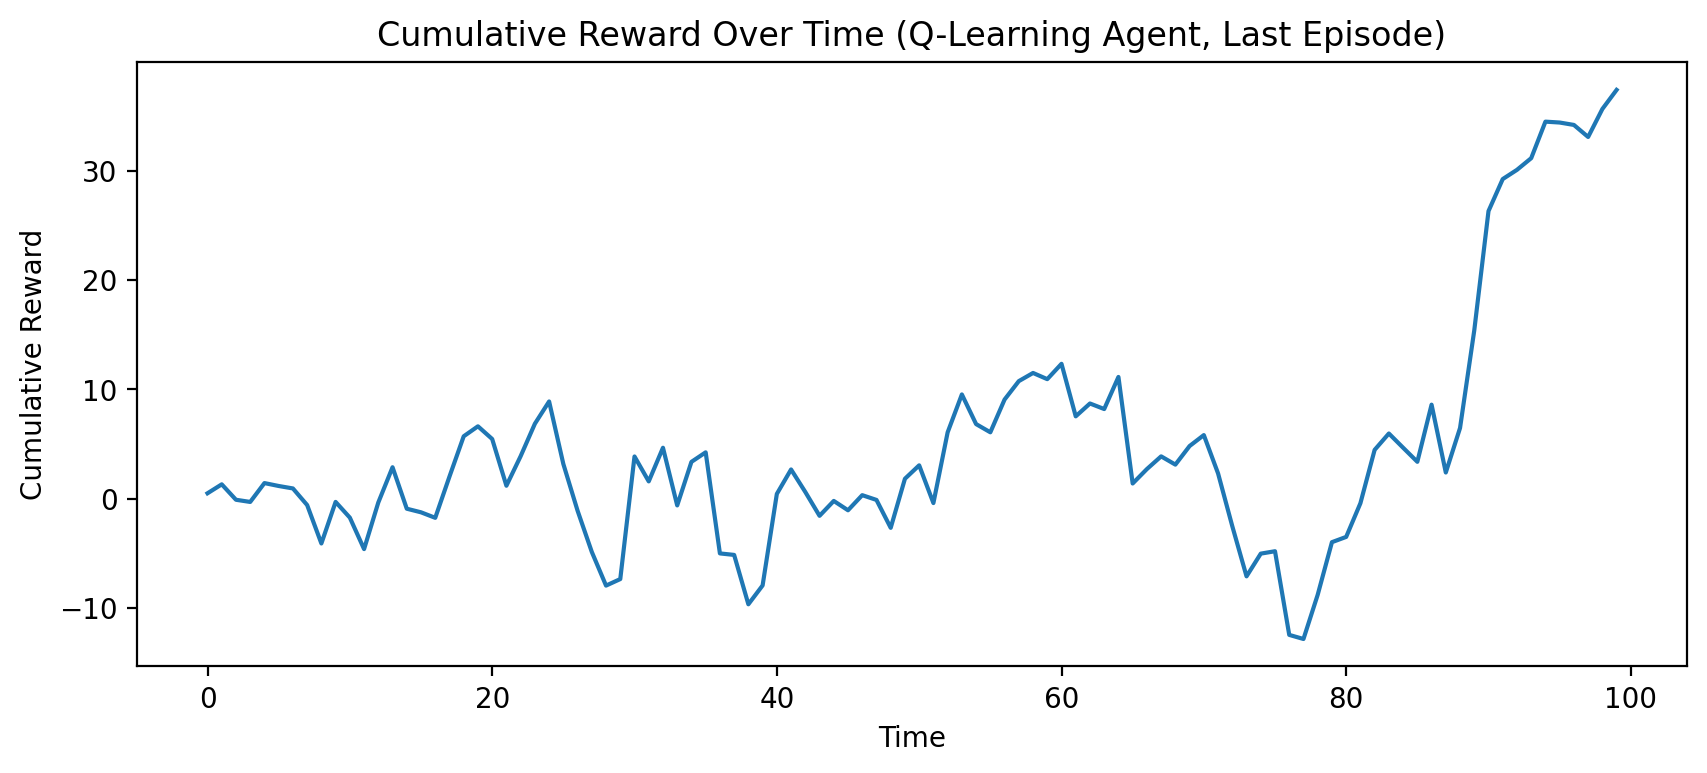

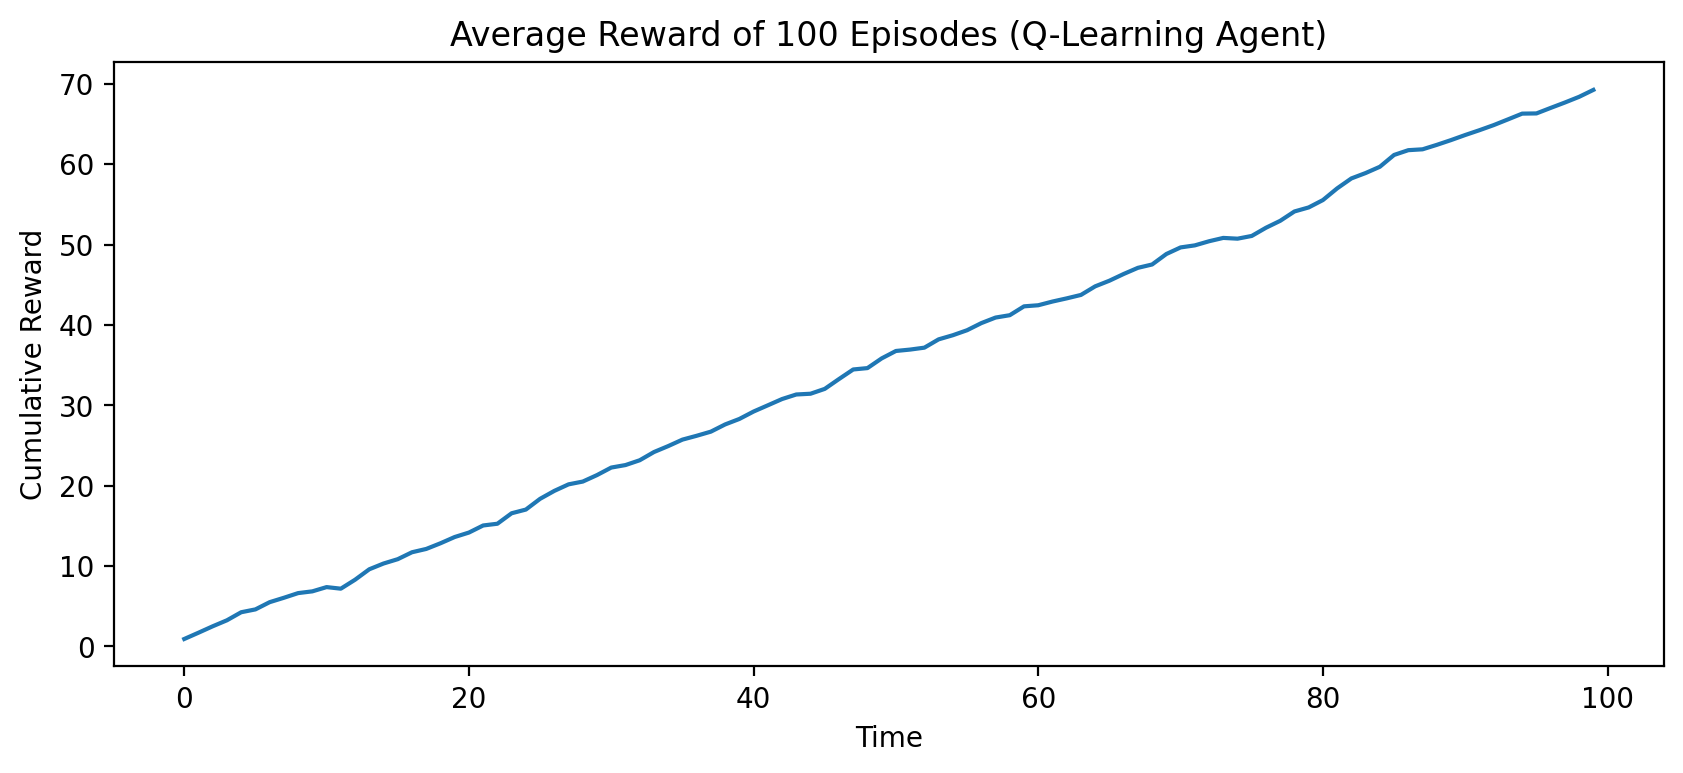

In [8]:
agent_q = QAgent(env_d=env.d, env_Q=env.Q, env_T=env.T, 
                 epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.01)
logs_q, final_rewards_q, average_rewards_q = multiple_experiment(
    agent_name='Q-Learning Agent', agent=agent_q, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Explore First Agent

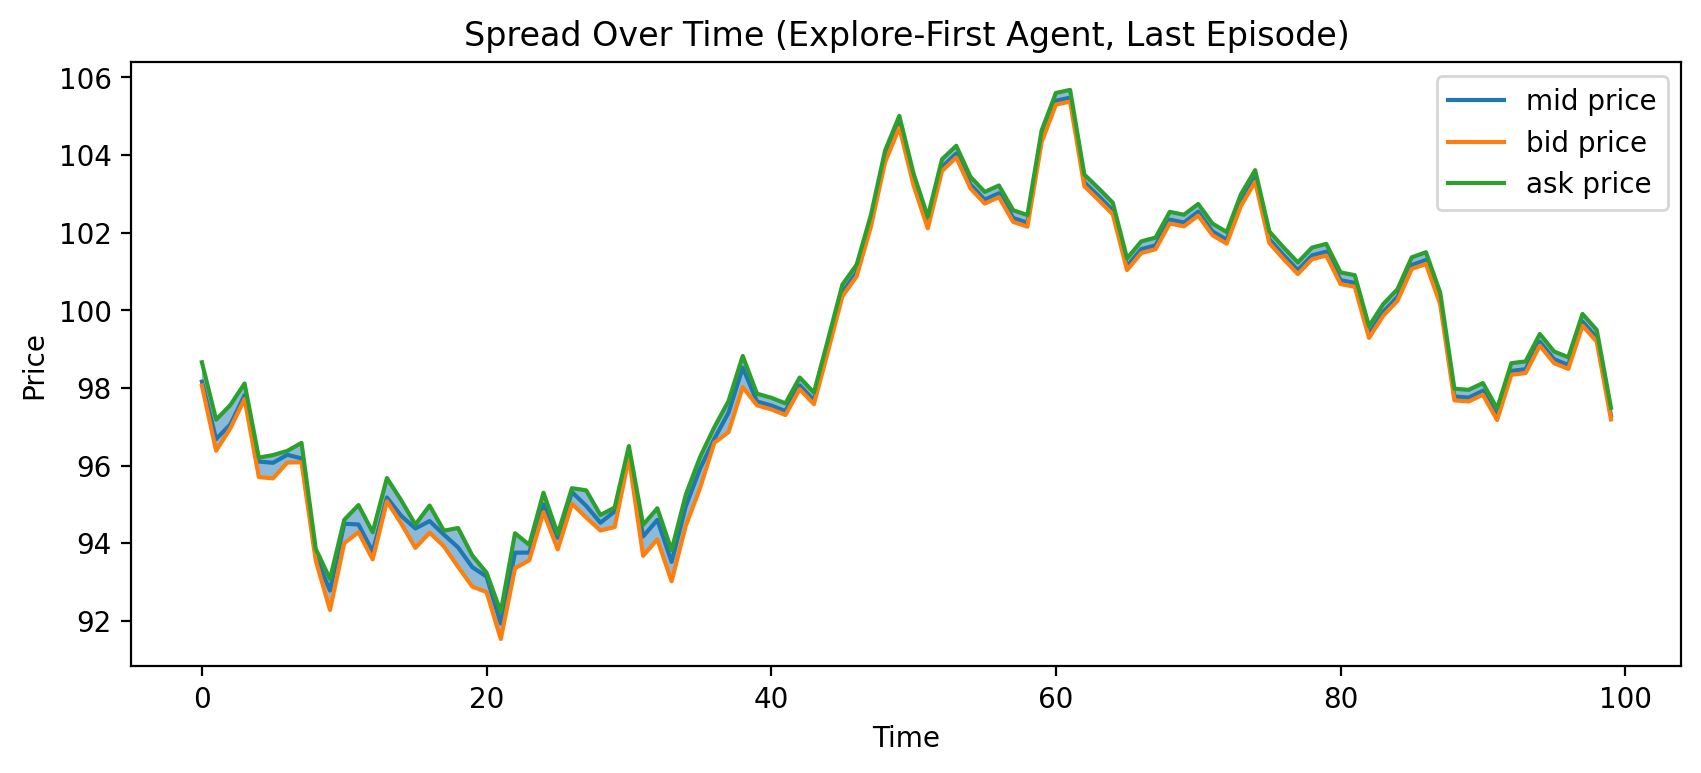

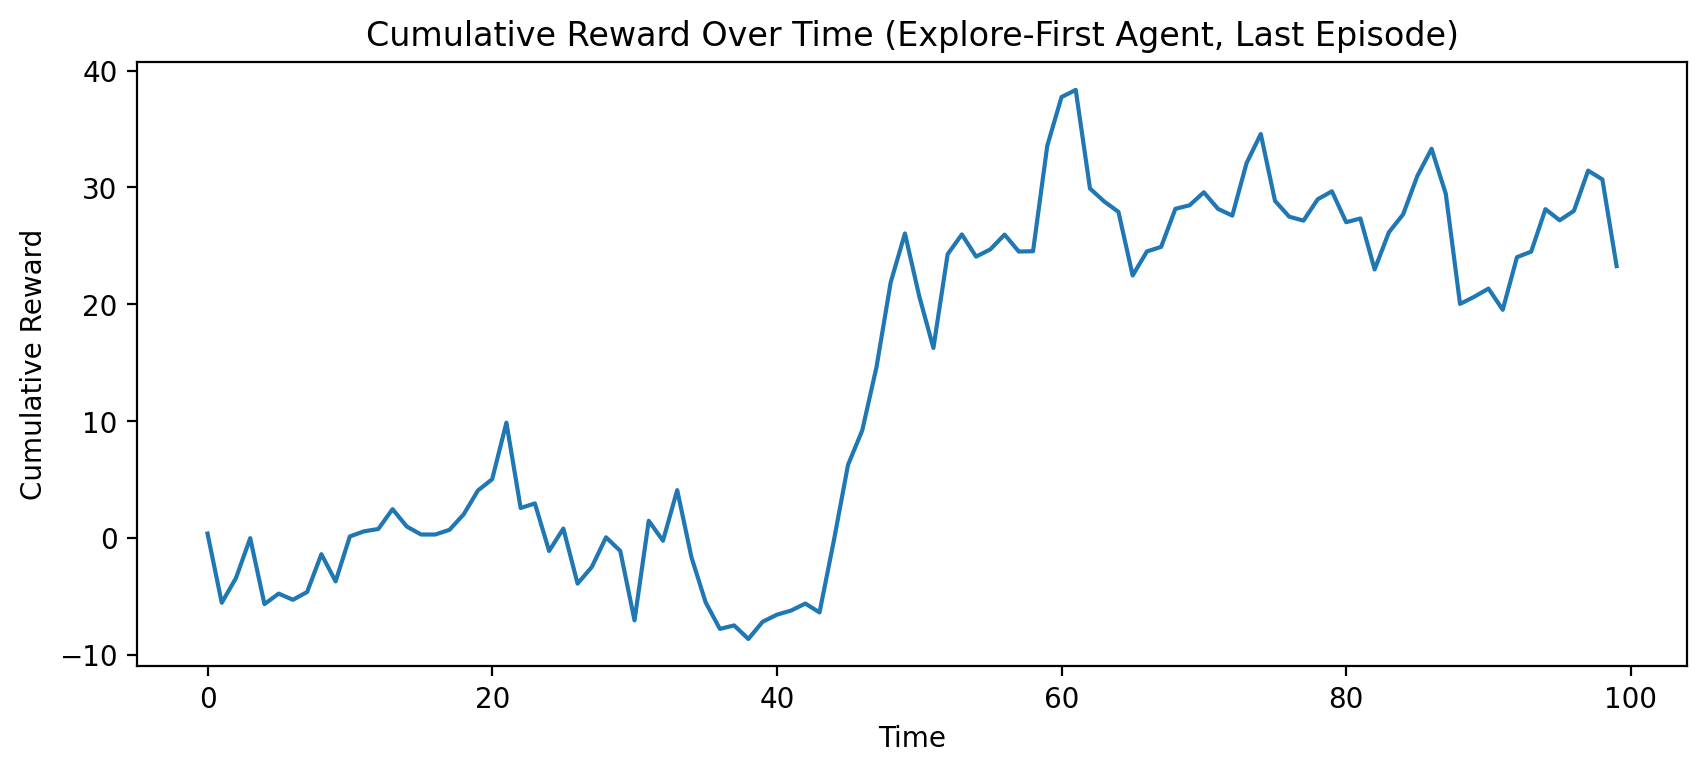

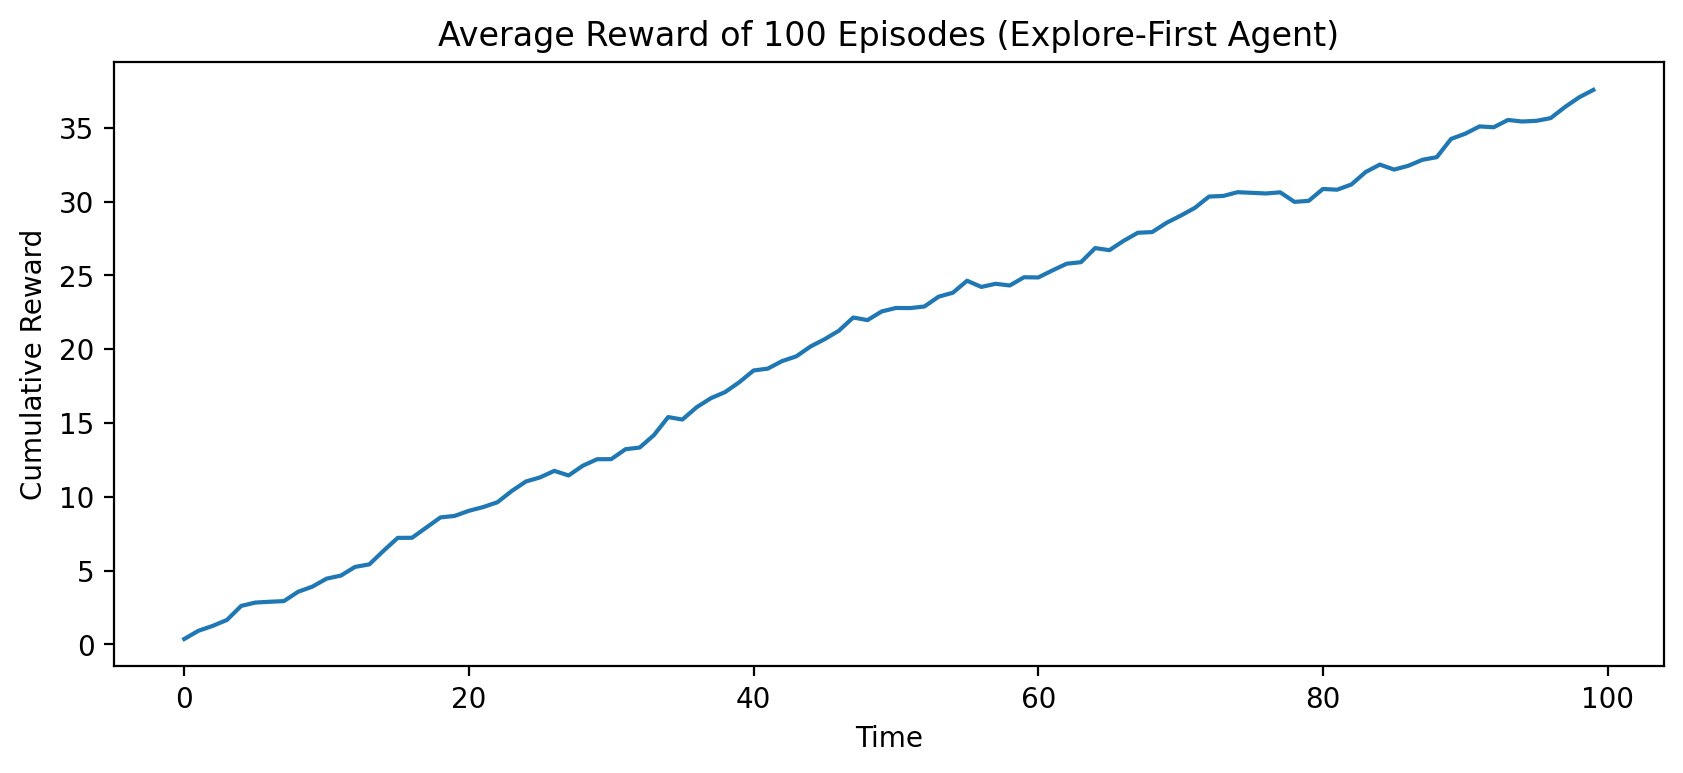

In [11]:
agent_explorefirst = ExploreFirstAgent(num_actions_bid=env.d, num_actions_ask=env.d, max_explore=30)
logs_ef, final_rewards_ef, average_rewards_ef = multiple_experiment(
    agent_name='Explore-First Agent', agent=agent_explorefirst, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### UCB Agent

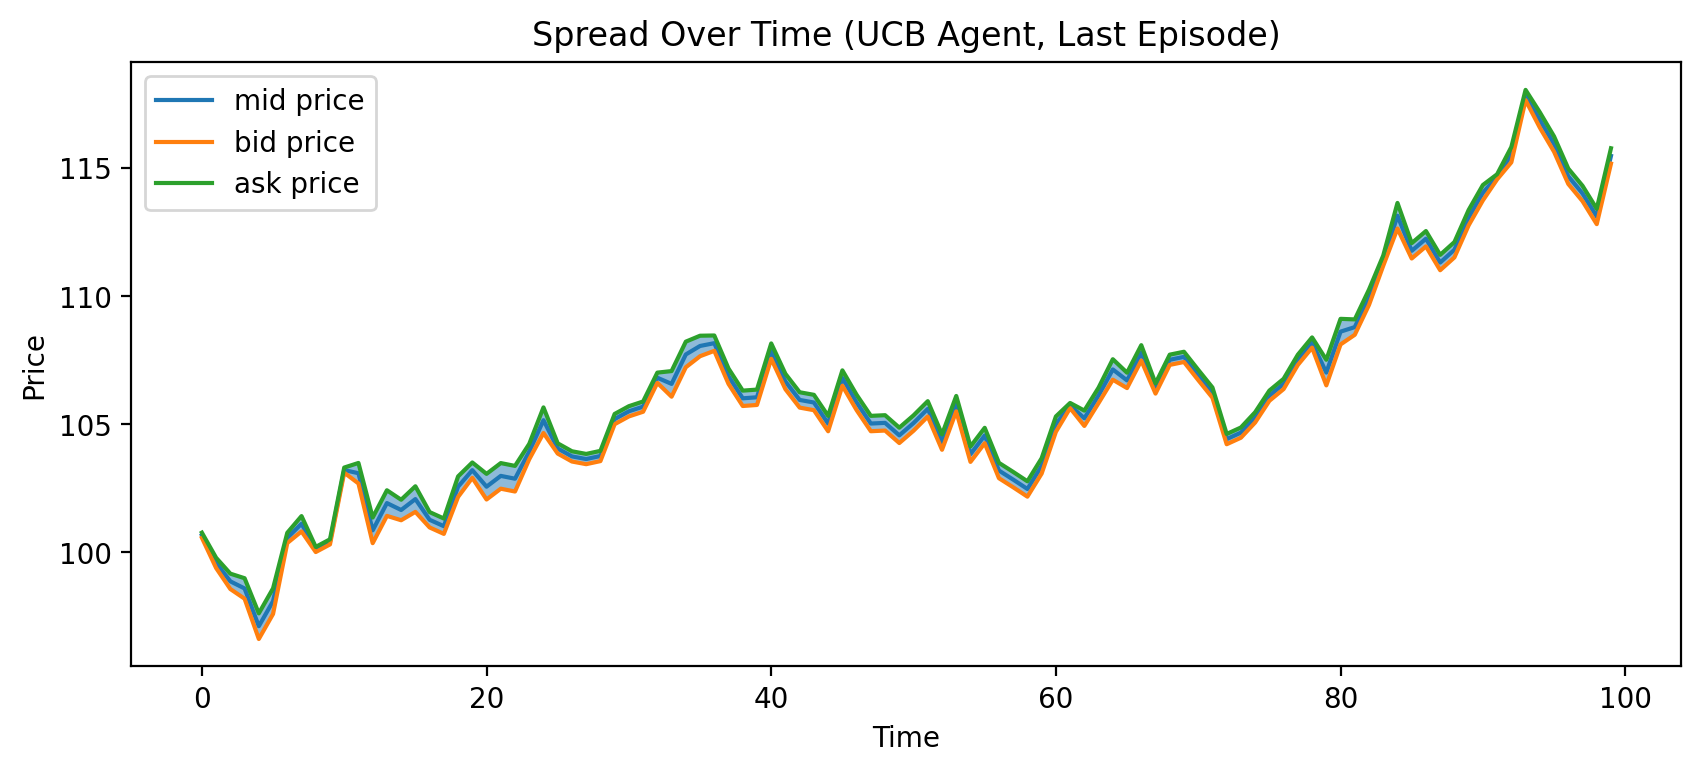

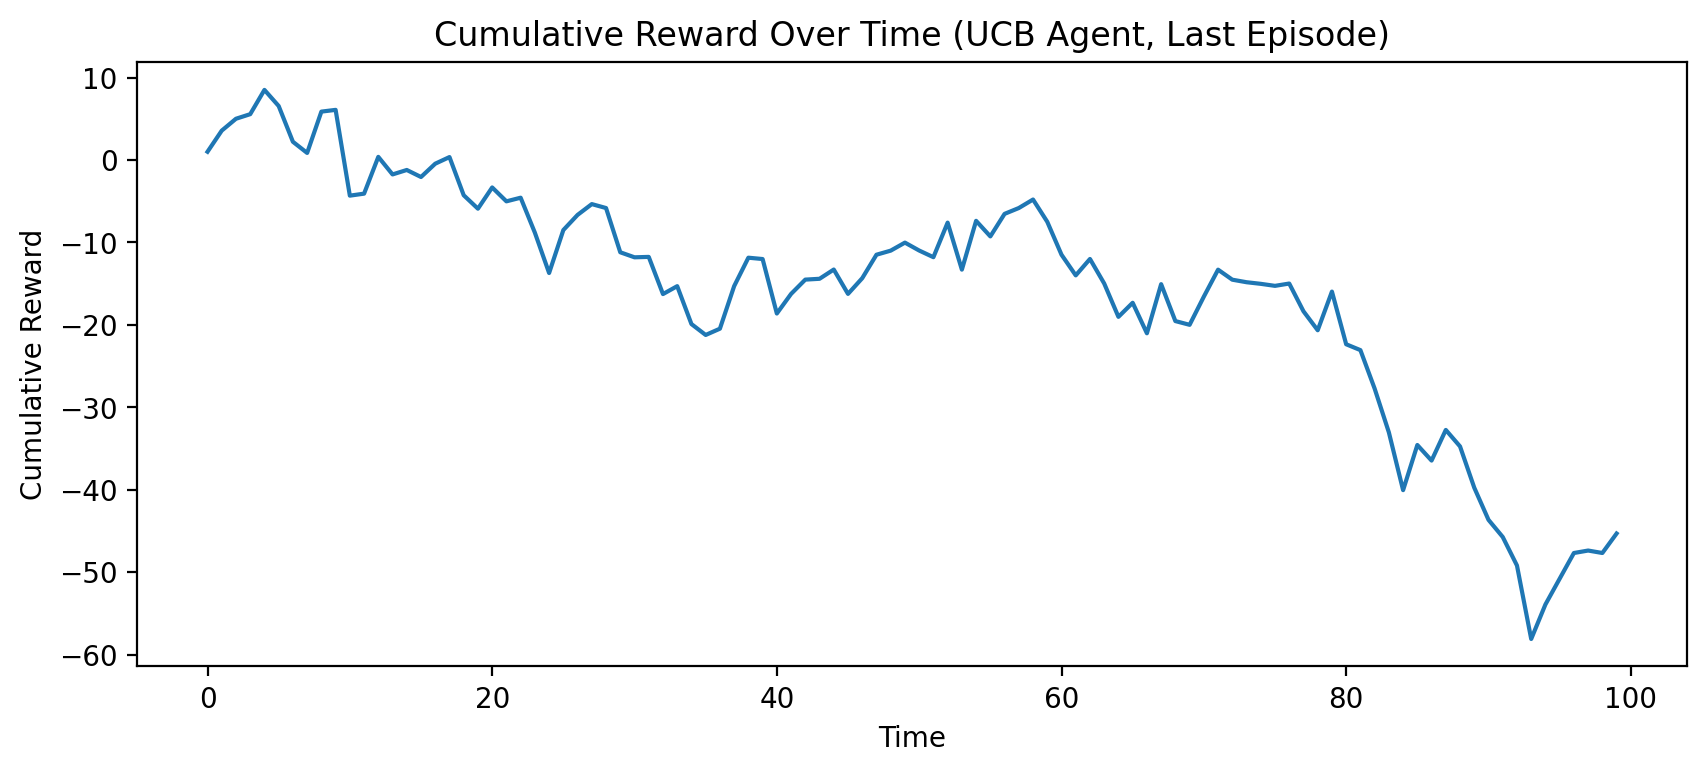

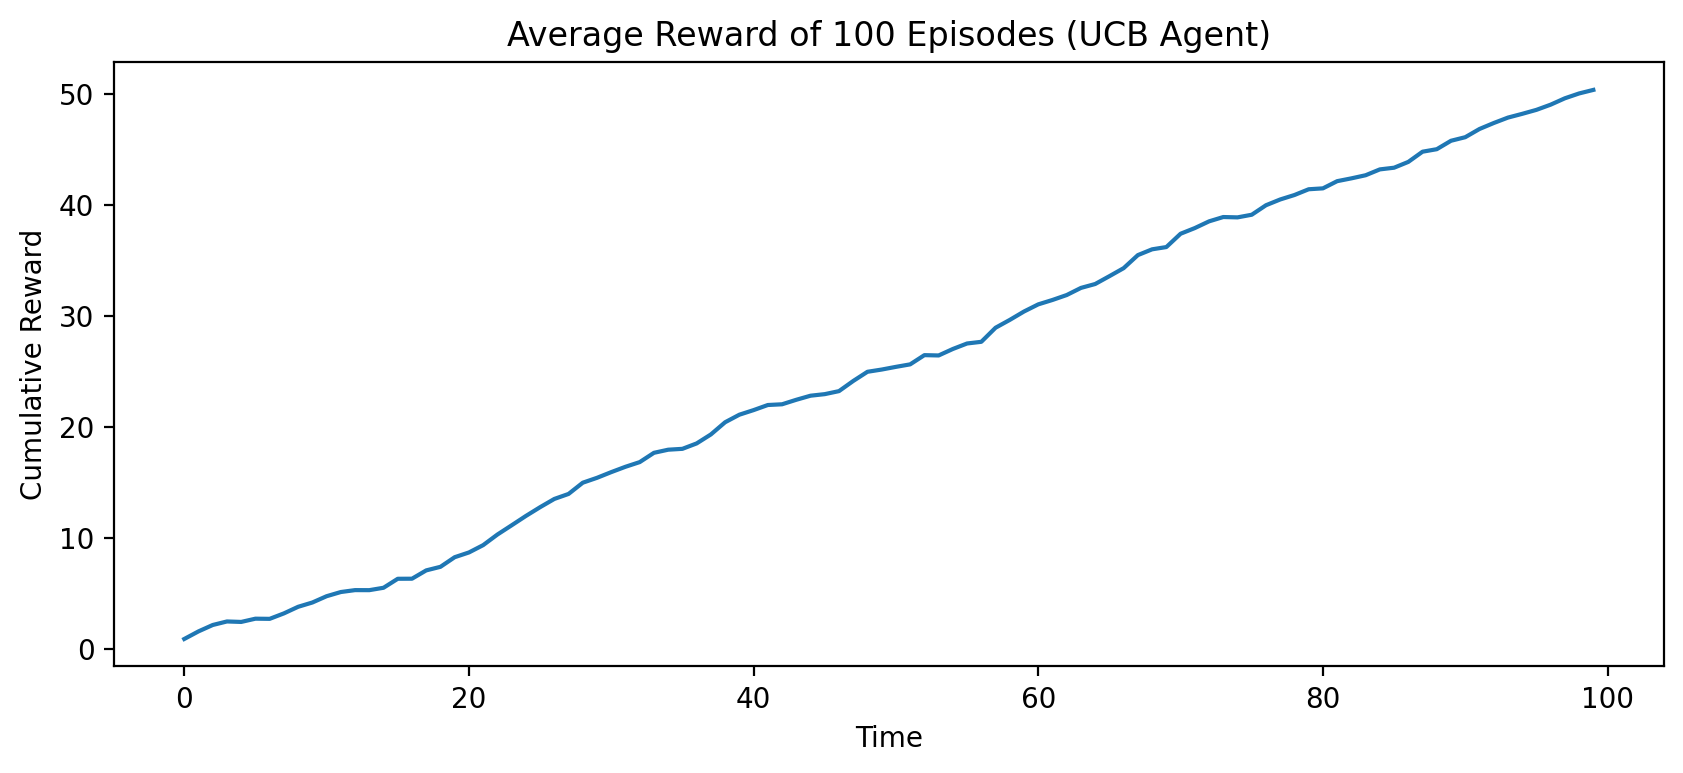

In [12]:
agent_ucb = UCBAgent(num_actions_bid=env.d, num_actions_ask=env.d)
logs_ucb, final_rewards_ucb, average_rewards_ucb = multiple_experiment(
    agent_name='UCB Agent', agent=agent_ucb, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Epsilon-Greedy Agent

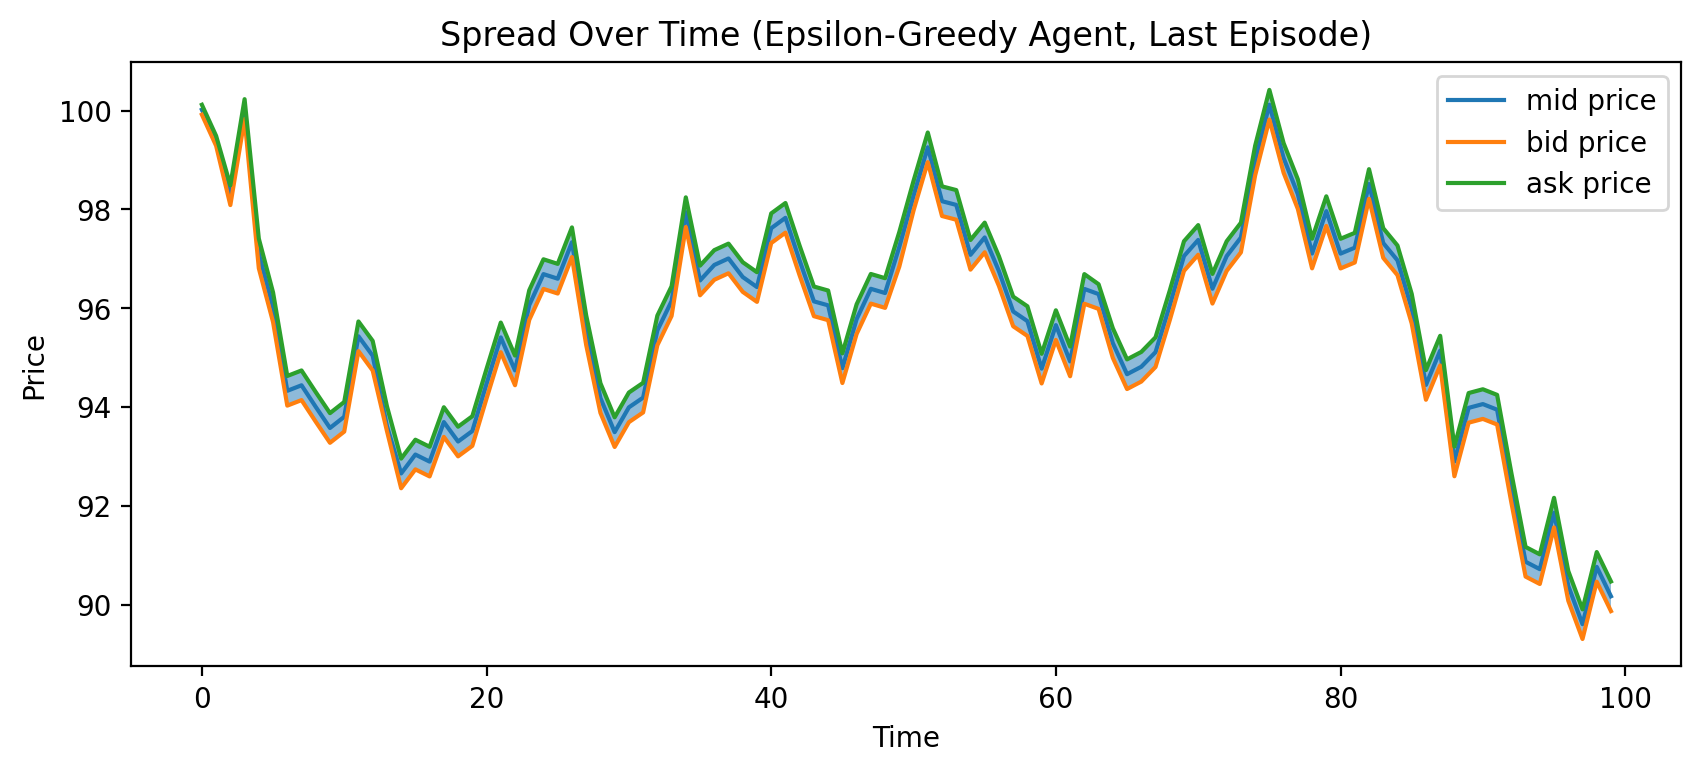

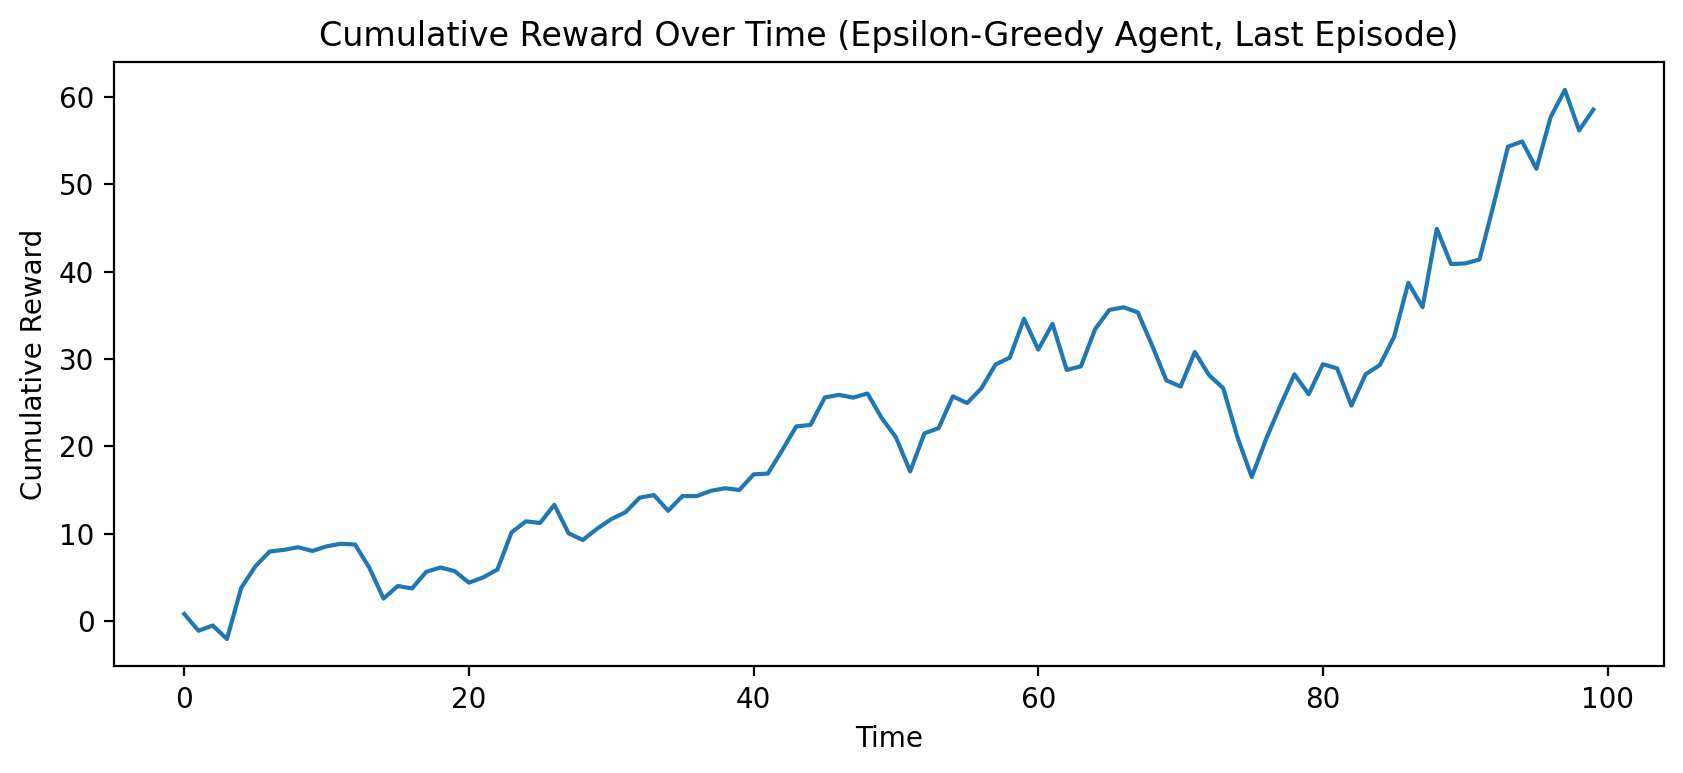

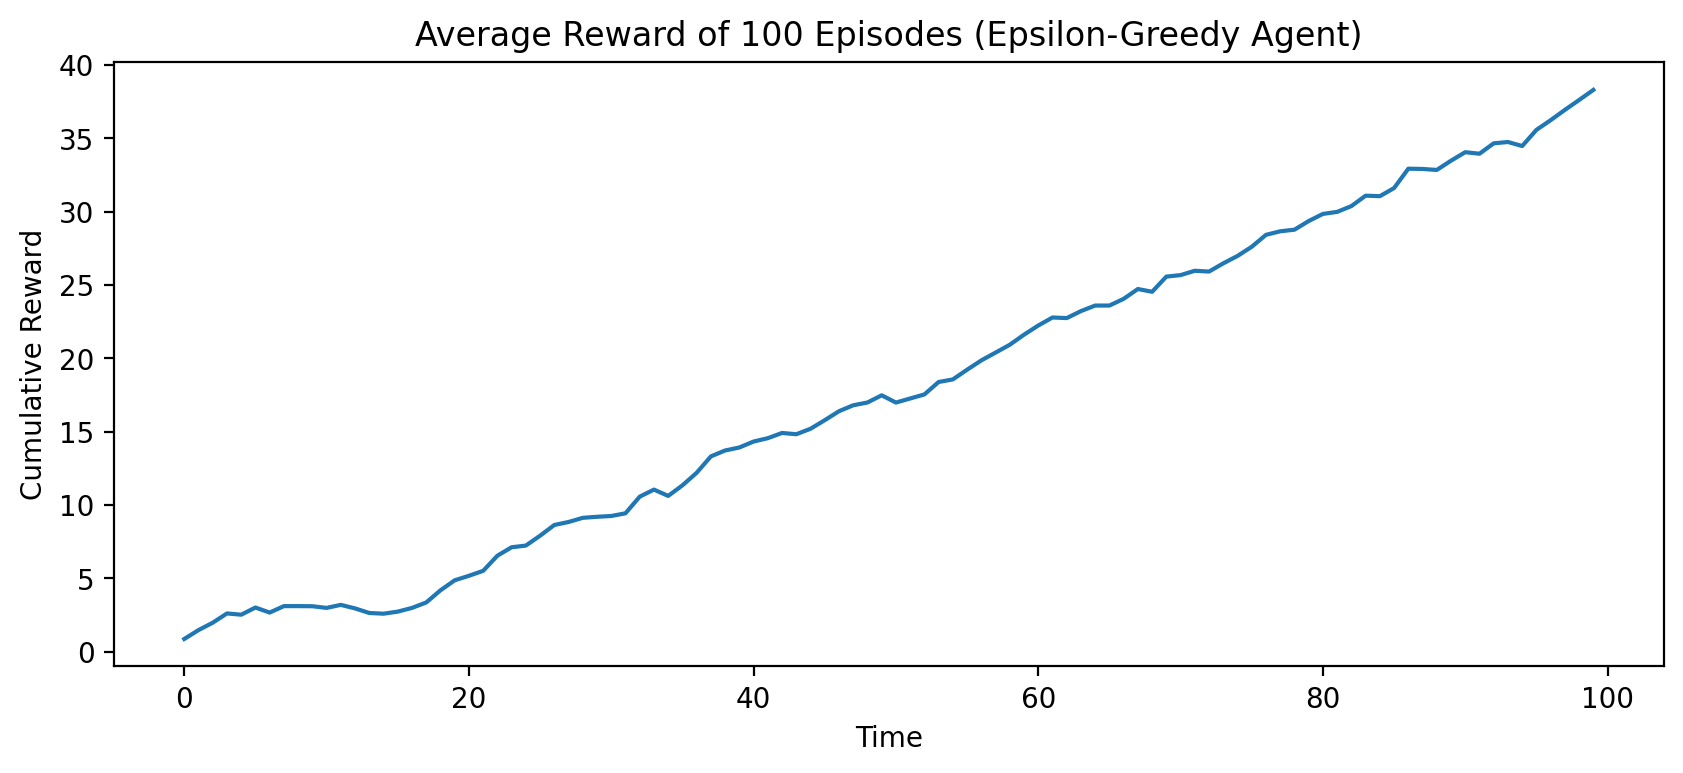

In [13]:
agent_epsilongreedy = EpsilonGreedyAgent(num_actions_bid=env.d, num_actions_ask=env.d, epsilon=0.1)
logs_eg, final_rewards_eg, average_rewards_eg = multiple_experiment(
    agent_name='Epsilon-Greedy Agent', agent=agent_epsilongreedy, env=env, num_episodes=100, 
    show_each=False, show_last=True, show_average=True)

### Decay-Epsilon-Greedy Agent

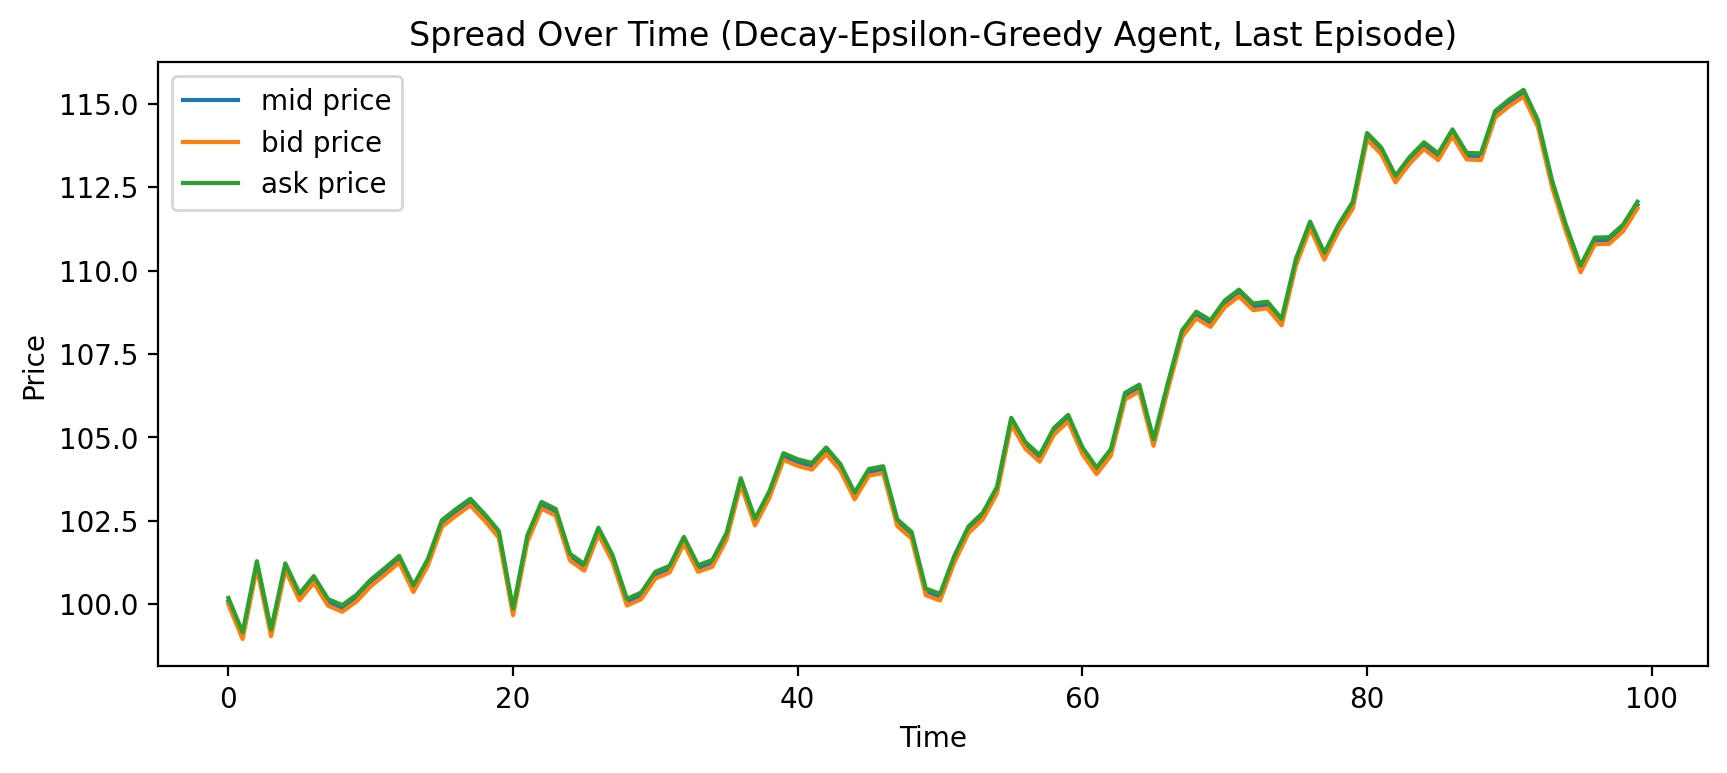

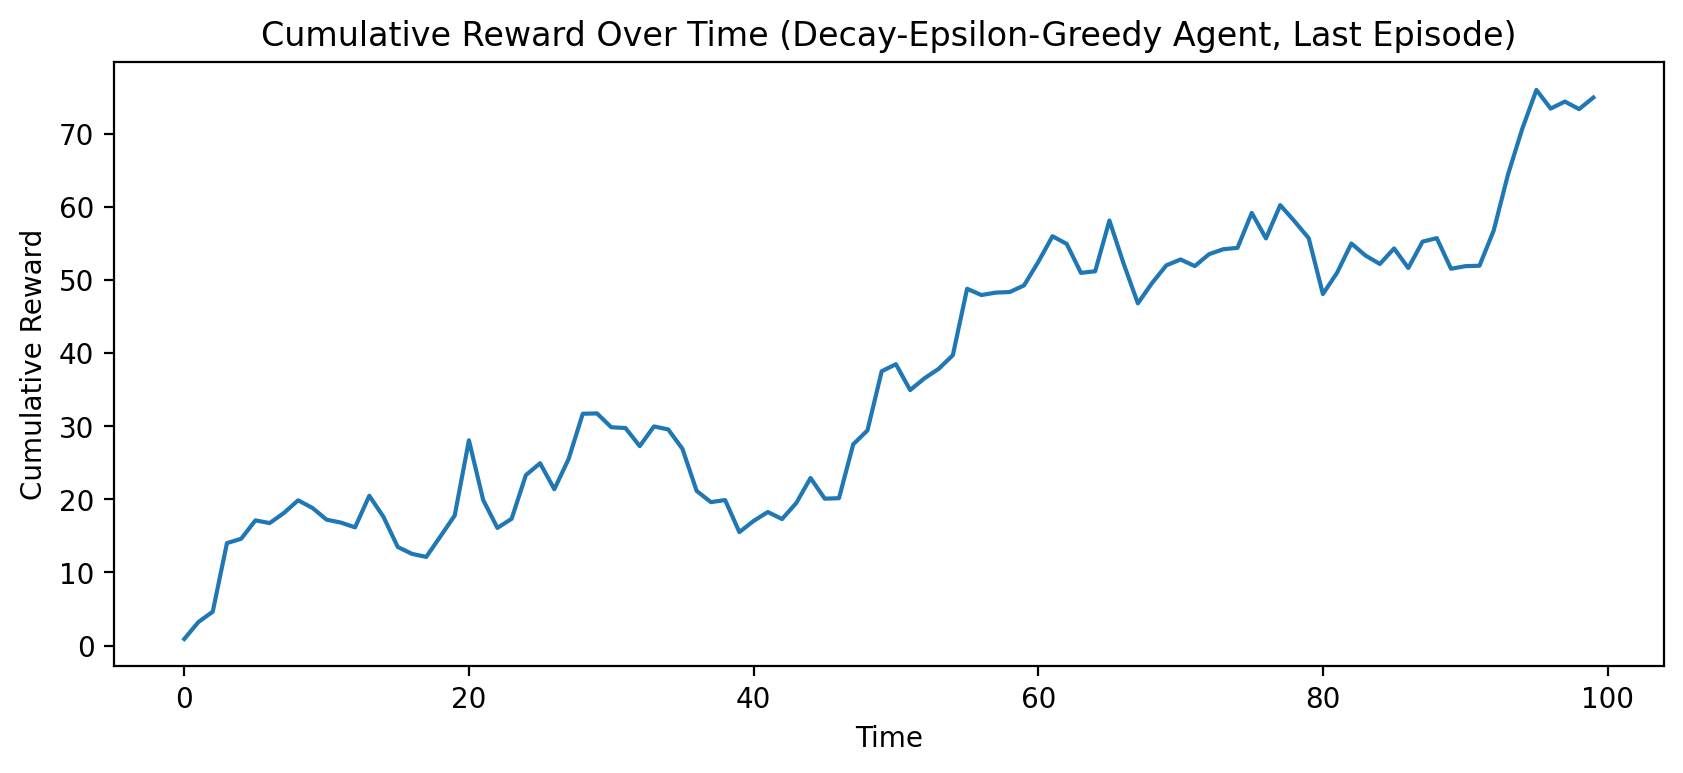

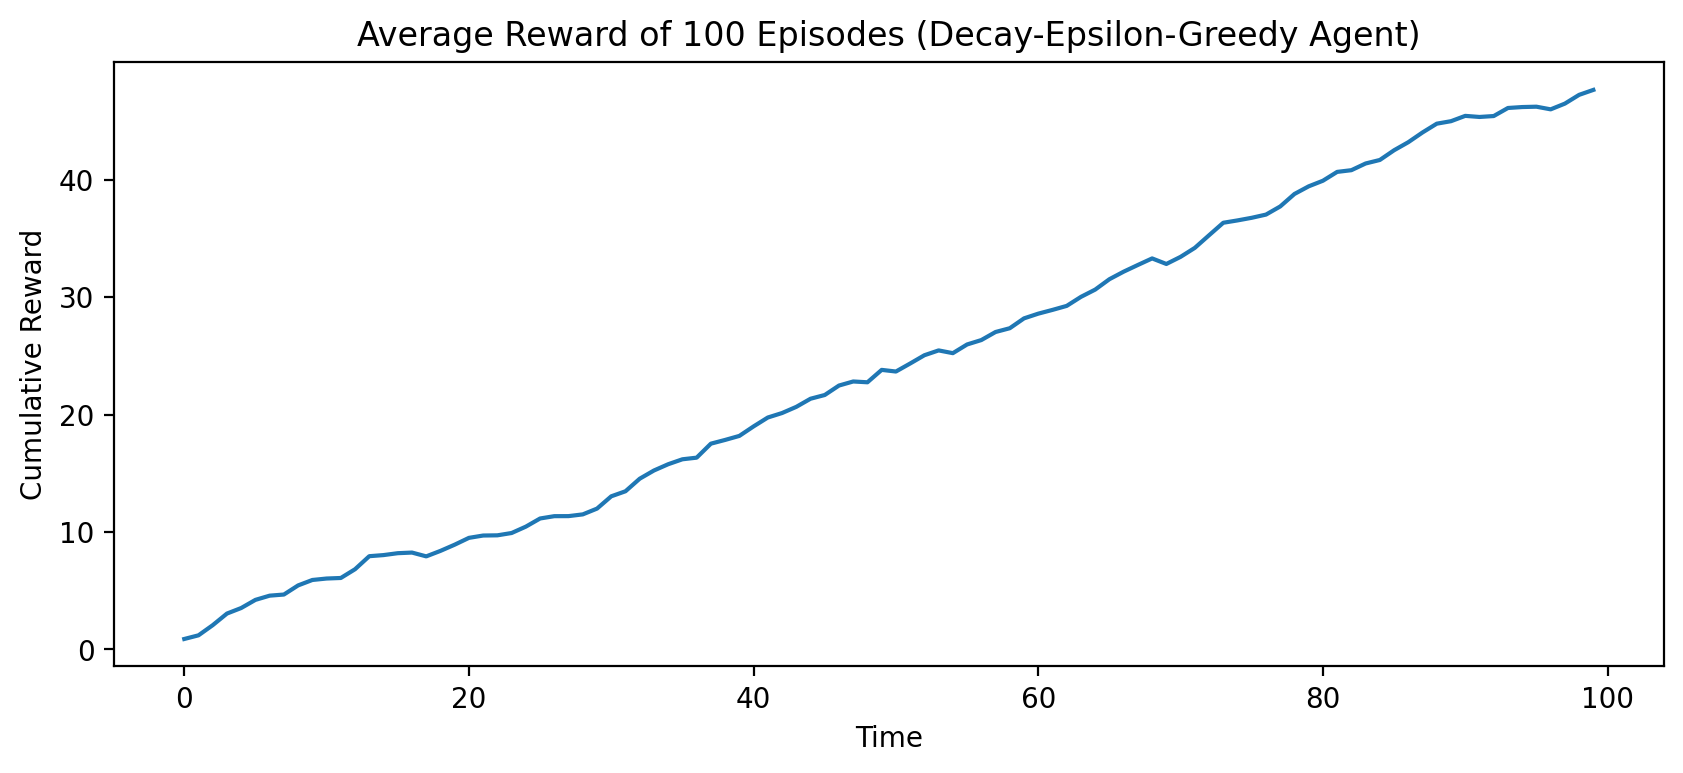

In [14]:
agent_decayepsilongreedy = DecayEpsilonGreedyAgent(num_actions_bid=env.d, num_actions_ask=env.d, 
                                                   epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.01)
logs_deg, final_rewards_deg, average_rewards_deg = multiple_experiment(
    agent_name='Decay-Epsilon-Greedy Agent', agent=agent_decayepsilongreedy, env=env, num_episodes=100,
    show_each=False, show_last=True, show_average=True)

### Evaluate

In [15]:
final_rewards = {
    'Random Agent': final_rewards_random,
    'Q-Learning Agent': final_rewards_q,
    'Explore-First Agent': final_rewards_ef,
    'UCB Agent': final_rewards_ucb,
    'Epsilon-Greedy Agent': final_rewards_eg,
    'Decay-Epsilon-Greedy Agent': final_rewards_deg,
}
average_rewards = {
    'Random Agent': average_rewards_random,
    'Q-Learning Agent': average_rewards_q,
    'Explore-First Agent': average_rewards_ef,
    'UCB Agent': average_rewards_ucb,
    'Epsilon-Greedy Agent': average_rewards_eg,
    'Decay-Epsilon-Greedy Agent': average_rewards_deg,
}

In [17]:
final_rewards_df = pd.DataFrame(final_rewards).describe()
final_rewards_df

,Random Agent,Q-Learning Agent,Explore-First Agent,UCB Agent,Epsilon-Greedy Agent,Decay-Epsilon-Greedy Agent
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,32.571157,69.254207,37.562148,50.342144,38.298058,47.642236
std,31.146421,34.648301,31.755429,40.112167,39.451423,44.625351
min,-41.467780,-34.813192,-42.423061,-46.907182,-37.489966,-59.631888
25%,10.223032,48.703762,13.898359,23.088364,7.982933,11.785983
50%,35.267201,69.088669,37.382275,53.102285,36.291091,48.233479
75%,55.274883,94.051431,59.071857,76.900209,62.278837,81.017665
max,113.103372,135.274174,115.851645,149.323870,132.827663,144.249165


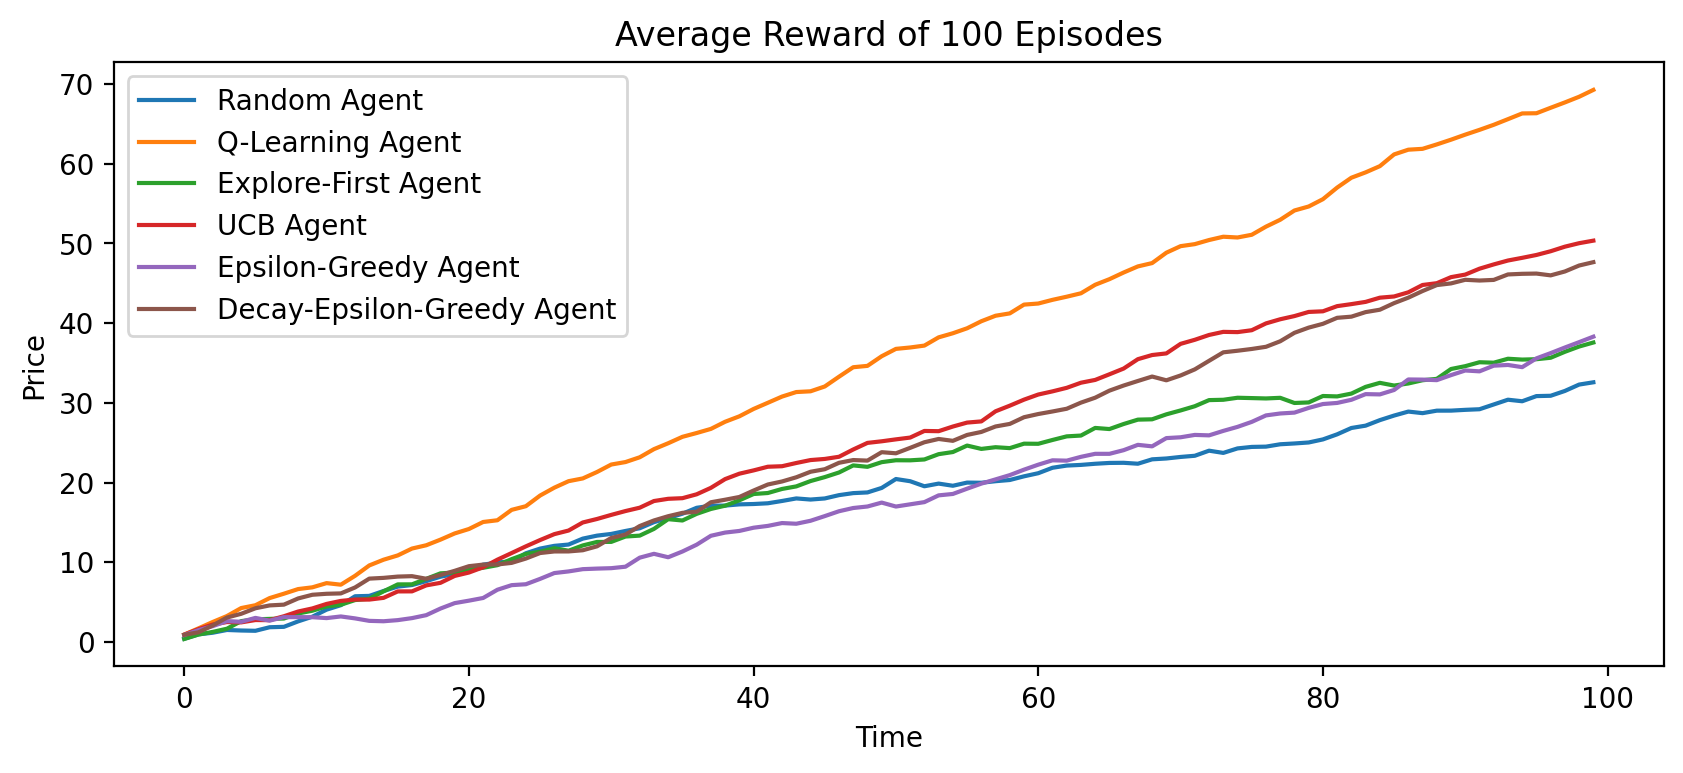

In [18]:
plt.figure(figsize=(10,4), dpi=200)
for agent, avg_reward in average_rewards.items():
    plt.plot(avg_reward, label=agent)
plt.legend()
plt.title(f'Average Reward of 100 Episodes')
plt.ylabel('Price')
plt.xlabel('Time')
plt.show()